In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import xgboost as xgb


In [6]:
flights = pd.read_csv('data/flights_cleaned.csv').drop(columns=['Unnamed: 0'])

In [7]:
def time_row(row):
    row_int = int(row)
    row_str = str(row_int)
    len_row = len(row_str)
    if len_row == 1:
        minute = '0' + row_str
        hour = '00'
        row = hour + ':' + minute
    if len_row == 2:
        minute =  row_str[0] + row_str[1]
        hour = '00'
        row = hour + ':' + minute
    if len_row == 3:
        minute = row_str[1]+row_str[2]
        hour = '0' + row_str[0]
        row = hour + ':' + minute
    elif len_row == 4:
        minute = row_str[2] + row_str[3]
        hour = row_str[0] + row_str[1]
        row = hour + ':' + minute
        if row == '24:00':
            row = '23:59'
    return str(row)

In [8]:
flights['crs_dep_time'] = flights['crs_dep_time'].apply(time_row)
flights['dep_time'] = flights['dep_time'].apply(time_row)
flights['wheels_off'] = flights['wheels_off'].apply(time_row)
flights['wheels_on'] = flights['wheels_on'].apply(time_row)
flights['crs_arr_time'] = flights['crs_arr_time'].apply(time_row)
flights['arr_time'] = flights['arr_time'].apply(time_row)

In [9]:
#lets create year, month and day
flights['fl_date'] = pd.to_datetime(flights['fl_date'],format='%Y-%m-%d')
flights['year'] = pd.DatetimeIndex(flights['fl_date']).year
flights['month'] = pd.DatetimeIndex(flights['fl_date']).month
flights['day'] = pd.DatetimeIndex(flights['fl_date']).day

In [11]:
#lets change the time columns format to time
flights['crs_dep_time'] = pd.to_datetime(flights['crs_dep_time'],format="%H:%M").dt.time
flights['dep_time'] = pd.to_datetime(flights['dep_time'],format="%H:%M").dt.time
flights['wheels_off'] = pd.to_datetime(flights['wheels_off'],format="%H:%M").dt.time
flights['wheels_on'] = pd.to_datetime(flights['wheels_on'],format="%H:%M").dt.time
flights['crs_arr_time'] = pd.to_datetime(flights['crs_arr_time'],format='%H:%M').dt.time
flights['arr_time'] = pd.to_datetime(flights['arr_time'],format="%H:%M").dt.time

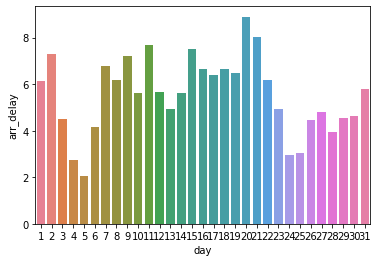

In [12]:
#just visualizing day and departure delay
ax = sns.barplot(x="day", y="arr_delay", data=flights, palette="husl", ci=None)

In [13]:
#Calculating different types of delay

total = flights['mkt_unique_carrier'].count()
ontime = flights[flights['arr_delay'] == 0]['mkt_unique_carrier'].count()
ontime_percent = ontime/total*100
print('Ontime: ',ontime_percent)

small_delay = flights[flights['arr_delay'] <= 15]['mkt_unique_carrier'].count()
small_percent = small_delay/total*100
print('Small delay: ', small_percent)


large = flights[flights['arr_delay'] >= 60]['mkt_unique_carrier'].count()
large_percent = large/total*100
print('Large delay: ', large_percent)

Ontime:  1.9177616481667203
Small delay:  81.2415645344983
Large delay:  6.699076985840318


In [14]:
#dropping the large delays, they seem to be outlier
flights = flights[flights['dep_delay'] <= 15]

### Feature Engineering

In [15]:
def time_to_sec(row):
    return (row.hour*3600+row.minute*60)

In [16]:
#TAKING THE DEPARTURE TIME
flights['crs_hour'] = flights['crs_arr_time'].apply(time_to_sec)
flights['crs_arr_hour'] = flights['crs_arr_time'].apply(lambda x:x.hour)

In [17]:
#lets encode airline and origin city
flights = flights[['mkt_unique_carrier','dest','crs_arr_time','crs_hour','arr_delay','crs_arr_hour']]
label = LabelEncoder()
flights['mkt_unique_carrier'] = label.fit_transform(flights['mkt_unique_carrier'])
flights['dest'] = label.fit_transform(flights['dest'])

In [18]:
features = ['mkt_unique_carrier','dest','crs_arr_hour']
X = flights[features]
y = flights['arr_delay']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=123)

In [59]:
# #instantiating the labelencoder
min_max = preprocessing.MinMaxScaler()
x = X_train.values
cols = X_train.columns
x_scaled = min_max.fit_transform(x)
X_train = pd.DataFrame(x_scaled,columns=cols)

x_test = X_test.values
cols = X_test.columns
x_test_scaled = min_max.fit_transform(x_test)
X_test= pd.DataFrame(x_test_scaled,columns=cols)
# # #Merge test data to normalize
# test_merged = pd.concat([X_test,y_test],axis=1)
# cols_test = test_merged.columns
# values_of_test = test_merged.values
# values_of_test_scaled=min_max.fit_transform(values_of_test)
# test_merged = pd.DataFrame(values_of_test_scaled,columns=cols_test)

In [60]:
# # #dividing back into X and y

# X_train = train_merged.loc[:,train_merged.columns!='arr_delay']
# y_train = train_merged[['arr_delay']]

# X_test = test_merged.loc[:,test_merged.columns!='arr_delay']
# y_test = test_merged[['arr_delay']]

In [61]:
X_test

,mkt_unique_carrier,dest,crs_arr_hour
0,0.1,0.879032,0.782609
1,0.1,0.857527,0.826087
2,0.3,0.274194,0.782609
3,0.4,0.583333,0.695652
4,0.8,0.250000,0.521739
...,...,...,...
72335,0.2,0.491935,0.608696
72336,1.0,0.612903,0.391304
72337,0.0,0.491935,0.565217
72338,0.4,0.250000,0.260870


## Linear Regression

In [62]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

In [63]:
ridgereg = Ridge(alpha=0.0001)
poly = PolynomialFeatures(degree=5)
X_ = poly.fit_transform(X_train)
ridgereg.fit(X_,y_train)

Ridge(alpha=0.0001)

In [64]:
X_=poly.fit_transform(X_test)
results = ridgereg.predict(X_)

In [65]:
r2_score(y_test,results)

0.010088192919661898

### XGB Regression

In [66]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3,
                          learning_rate=0.1,
                          max_depth=100,
                          alpha=0.01,
                          n_estimators = 10)

In [67]:
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=0.01, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=100,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0.00999999978, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [68]:
preds = xg_reg.predict(X_test)

In [69]:
r2_score(y_test,preds)

-0.036679658857052155